# AllLife Credit Card Customer Segmentation

**Objective:**

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.



## Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

## Import data & Load Dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

sns.set(color_codes=True)

In [2]:
AllLifeData=pd.read_excel("Credit Card Customer Data.xlsx")
AllLifeData.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


- Avg Credit Limits need to be scaled 

In [3]:
AllLifeData.drop('Customer Key', axis=1, inplace=True)

- dropped Customer Key as this data I believe is redundant , Not adding any value to the overall clustering 

In [4]:
AllLifeData.shape

(660, 6)

In [5]:
AllLifeData.dtypes

Sl_No                  int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

- All Integer Values

In [6]:
AllLifeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


- all integer data

In [7]:
AllLifeData.describe()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


##  missing value check

In [8]:
AllLifeData.isnull().sum()

Sl_No                  0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- there is no missing values

## Perform univariate analysis

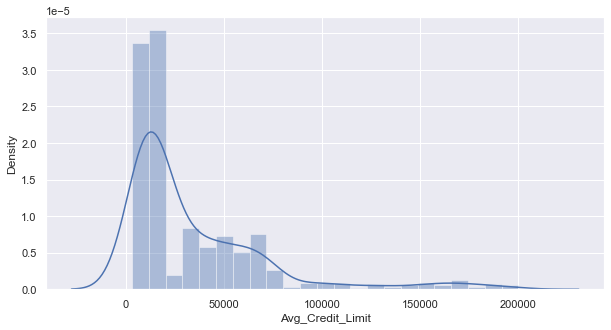

In [9]:
plt.figure(figsize=(10,5))
sns.distplot(AllLifeData.Avg_Credit_Limit);

- Average credit limit:
The majority of records do not have credit or have a low limit.

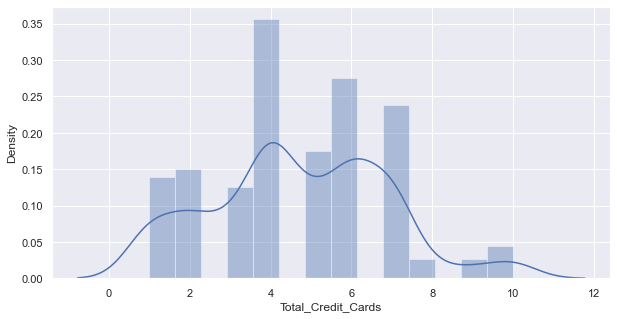

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(AllLifeData.Total_Credit_Cards);

- Total Credit Cards: Normally distributed

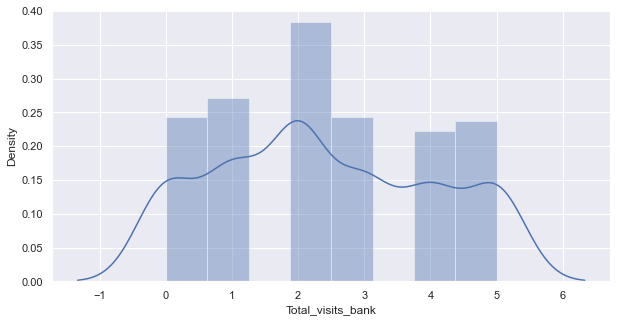

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(AllLifeData.Total_visits_bank);

- Total bank visits:
Once again, normally distributed variable.

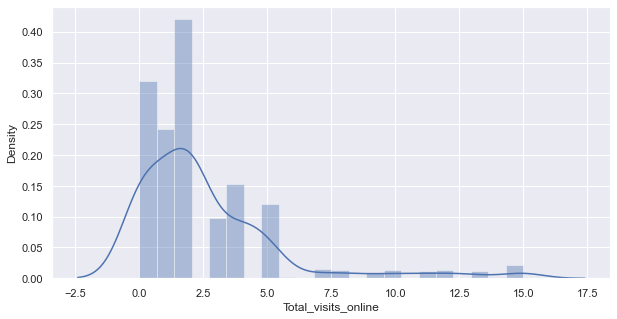

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(AllLifeData.Total_visits_online);

- Total Visits Online: The visitor data is Skewed 

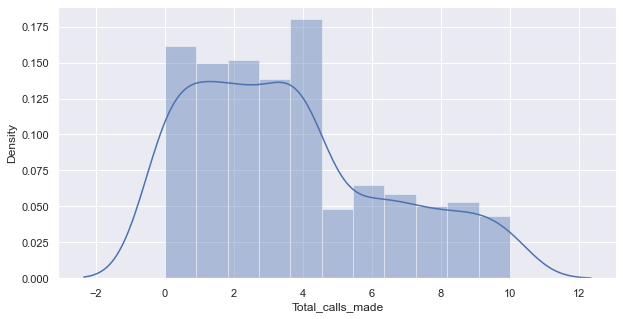

In [13]:
plt.figure(figsize=(10,5))
sns.distplot(AllLifeData.Total_calls_made);

- Total Calls made: Seems to me Normally distributed again

## Perfom Bivariate analysis & Heatmap 

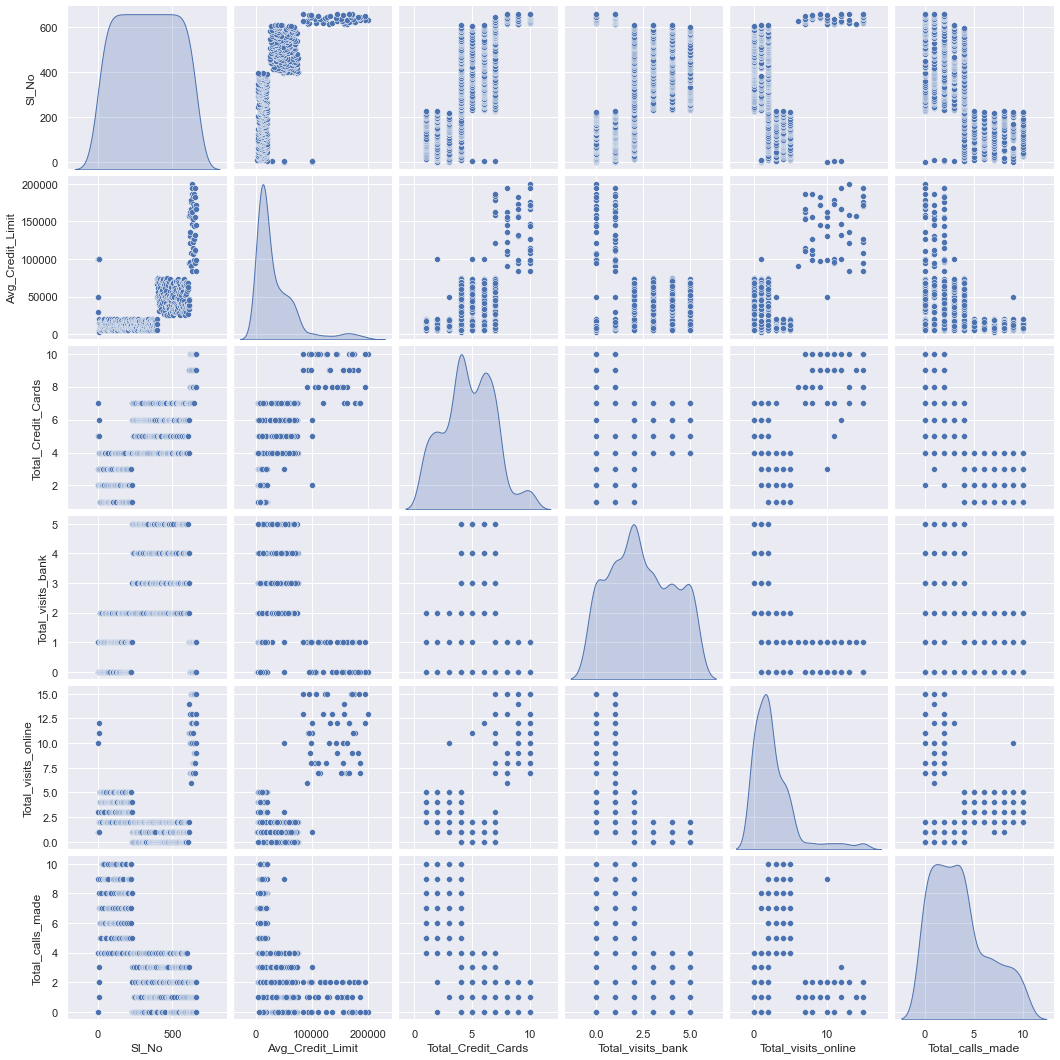

In [14]:
sns.pairplot(AllLifeData,diag_kind='kde')

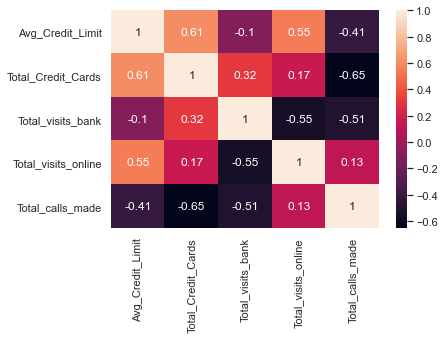

In [15]:
sns.heatmap(AllLifeData[['Avg_Credit_Limit', 
                         'Total_Credit_Cards', 
                         'Total_visits_bank', 
                         'Total_visits_online', 
                         'Total_calls_made']].corr(), annot=True);

- Observations
- Total Credit Cards Negatively correlated with Total calls made
- Avg Credit Limit with Total Credit cards are positively correlated
- Avg Credit Limits has 3 points
- Total Credit cards has 4 points
- Total Visit to Bank may have 5 points

## Perform feature engineering/transformation 

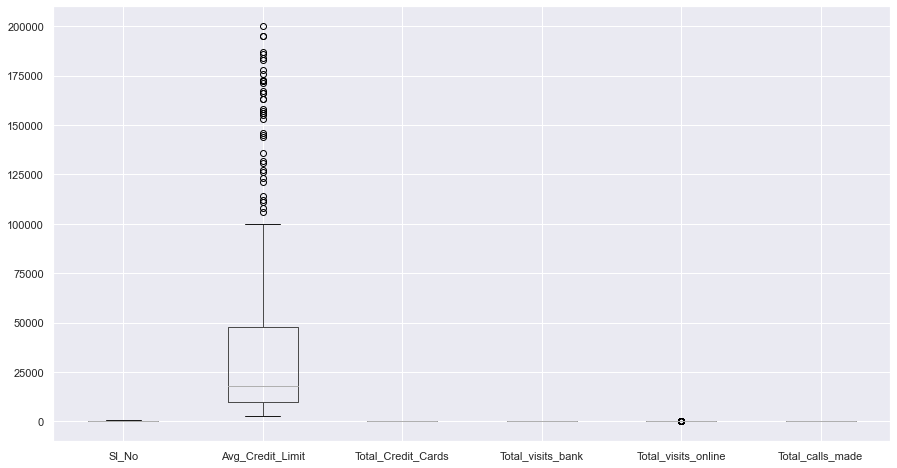

In [16]:
# Outlier Treatment

plt.figure(figsize=(15,8))

AllLifeData.boxplot()

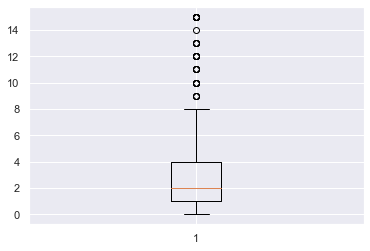

In [17]:
plt.boxplot(AllLifeData['Total_visits_online']);

- We see sone outliers for Avg credit Limit  & Total Visits Online

In [18]:
# Outlier Treatment

q1= AllLifeData.quantile(0.25)
q3= AllLifeData.quantile(0.75)
IQR = q3-q1
outliers = pd.DataFrame((AllLifeData >(q3+1.5*IQR)) | (AllLifeData < (q1-1.5*IQR))).sum(axis=0)
outliers

Sl_No                   0
Avg_Credit_Limit       39
Total_Credit_Cards      0
Total_visits_bank       0
Total_visits_online    37
Total_calls_made        0
dtype: int64

## Scale the data

In [19]:
from scipy.stats import zscore

AllLifeDataScaled = AllLifeData.apply(zscore)

## Finding optimal no. of clusters-Elbow Plot

Text(0.5, 1.0, 'Selecting K with Elbow method')

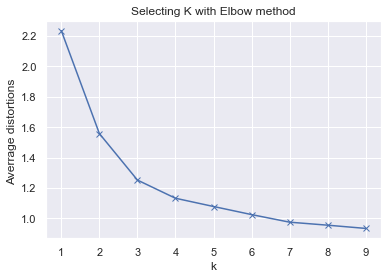

In [20]:
from scipy.spatial.distance import cdist
clusters= range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(AllLifeDataScaled)
    Prediction=model.predict(AllLifeDataScaled)
    meanDistortions.append(sum(np.min(cdist(AllLifeDataScaled,model.cluster_centers_, 'euclidean'),axis=1)) / AllLifeDataScaled
                          .shape[0])
    
plt.plot(clusters,meanDistortions,'bx-')
plt.xlabel('k')
plt.ylabel('Averrage distortions ')
plt.title('Selecting K with Elbow method')

- It shows the Bends are coming at 2 clusters and 3 clusters, Comparing Elbow Method and also observing Pairplot I will take K =3 for Clustering 

### KMeans Clustering with K = 3

In [21]:

final_model=KMeans(3)
final_model.fit(AllLifeDataScaled)
prediction=final_model.predict(AllLifeDataScaled)

#Append the prediction 
AllLifeDataScaled["GROUP"] = prediction
print("Groups Assigned : \n")
AllLifeDataScaled.head()

Groups Assigned : 



,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,-1.729428,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,-1.724180,0.410293,-0.787585,-1.473731,2.520519,1.891859,0
2,-1.718931,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-1.713683,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,-1.708434,1.740187,0.597334,-1.473731,3.202298,-0.203739,2


In [22]:
AllLifeData_Cluster = AllLifeDataScaled.groupby(['GROUP'])
AllLifeData_Cluster.mean()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,
0,-1.128668,-0.578301,-1.049045,-0.903869,0.316802,1.133055
1,0.472378,-0.028365,0.374929,0.675944,-0.554592,-0.553005
2,1.473714,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [23]:
K=AllLifeDataScaled.groupby('GROUP').mean().append(pd.DataFrame(AllLifeDataScaled.std()).T)
K.index = ['Phone', 'Online', 'In person', 'Mean']
K

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
Phone,-1.128668,-0.578301,-1.049045,-0.903869,0.316802,1.133055,NaN
Online,0.472378,-0.028365,0.374929,0.675944,-0.554592,-0.553005,NaN
In person,1.473714,2.831764,1.862226,-1.105763,2.827319,-0.874330,NaN
Mean,1.000758,1.000758,1.000758,1.000758,1.000758,1.000758,0.589574


- we see here is that there is a group which prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards. 
- The customers who prefer in-person interactions tend to have the least number of credit cards and the lowest credit limit. 
- The customers who contact via phonecall are in the middle.


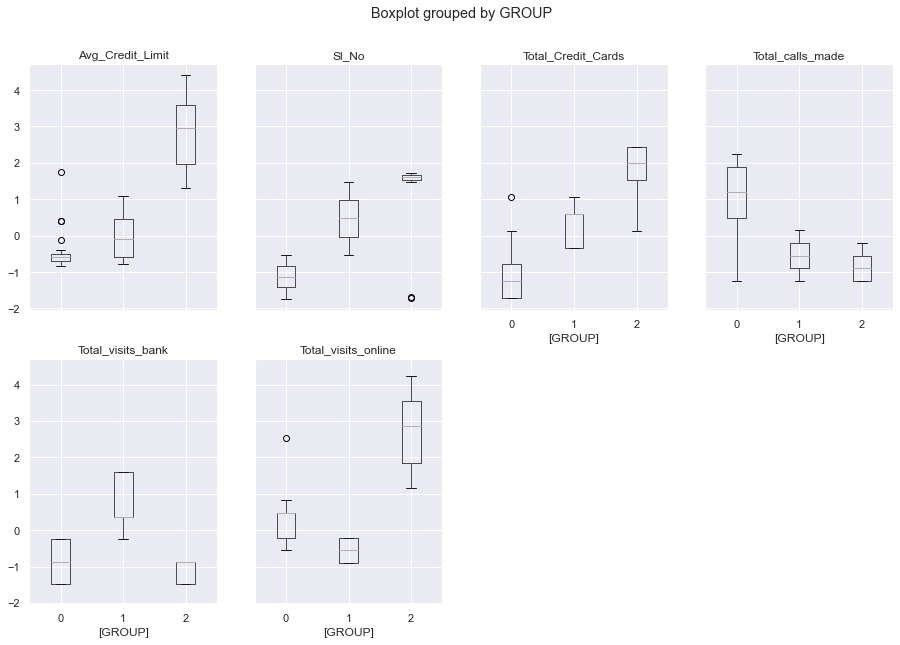

In [24]:
AllLifeDataScaled.boxplot(by='GROUP', layout = (2,4),figsize=(15,10));

-we see here is that there is a group which prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards.
The customers who prefer in-person interactions tend to have the least number of credit cards and the lowest credit limit.
The customers who contact via phonecall are in the middle.

## Hierarchical clustering

In [25]:
from sklearn.cluster import AgglomerativeClustering 

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')

model.fit(AllLifeDataScaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [26]:
AllLifeDataScaled['labels'] = model.labels_
AllLifeDataScaled.head(5)

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,labels
0,-1.729428,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0,0
1,-1.724180,0.410293,-0.787585,-1.473731,2.520519,1.891859,0,0
2,-1.718931,0.410293,1.058973,-0.860451,0.134290,0.145528,0,0
3,-1.713683,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0,0
4,-1.708434,1.740187,0.597334,-1.473731,3.202298,-0.203739,2,2


In [27]:
# AllLifeDataScaled.groupby(["labels"]).count()

In [28]:
AllLifeDataCluster = AllLifeDataScaled.groupby(['labels'])

AllLifeDataCluster.mean()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
labels,,,,,,,
0,-0.120796,-0.232112,-0.152641,0.090636,-0.231747,0.071666,0.629508
1,1.606085,2.877246,1.924548,-1.090431,2.818797,-0.894995,2.000000
2,-1.703185,1.740187,0.366514,-1.473731,3.031853,-0.378372,2.000000


### Linkage Method : Average

In [29]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist 

Z = linkage(AllLifeDataScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(AllLifeDataScaled))
c

0.9181164336759225

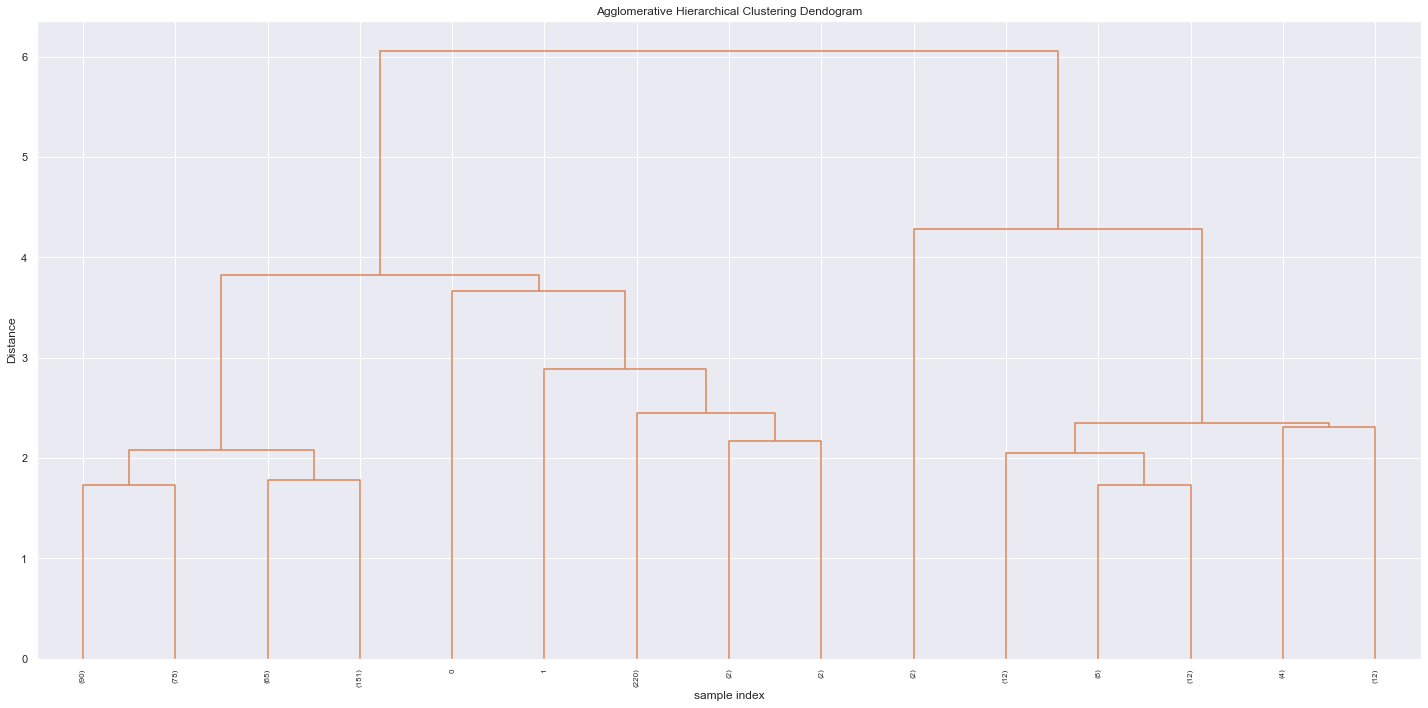

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, p=15,truncate_mode='lastp', leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

### Linkage Method : complete

In [31]:

Z = linkage(AllLifeDataScaled, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(AllLifeDataScaled))
c

0.9026227837510734

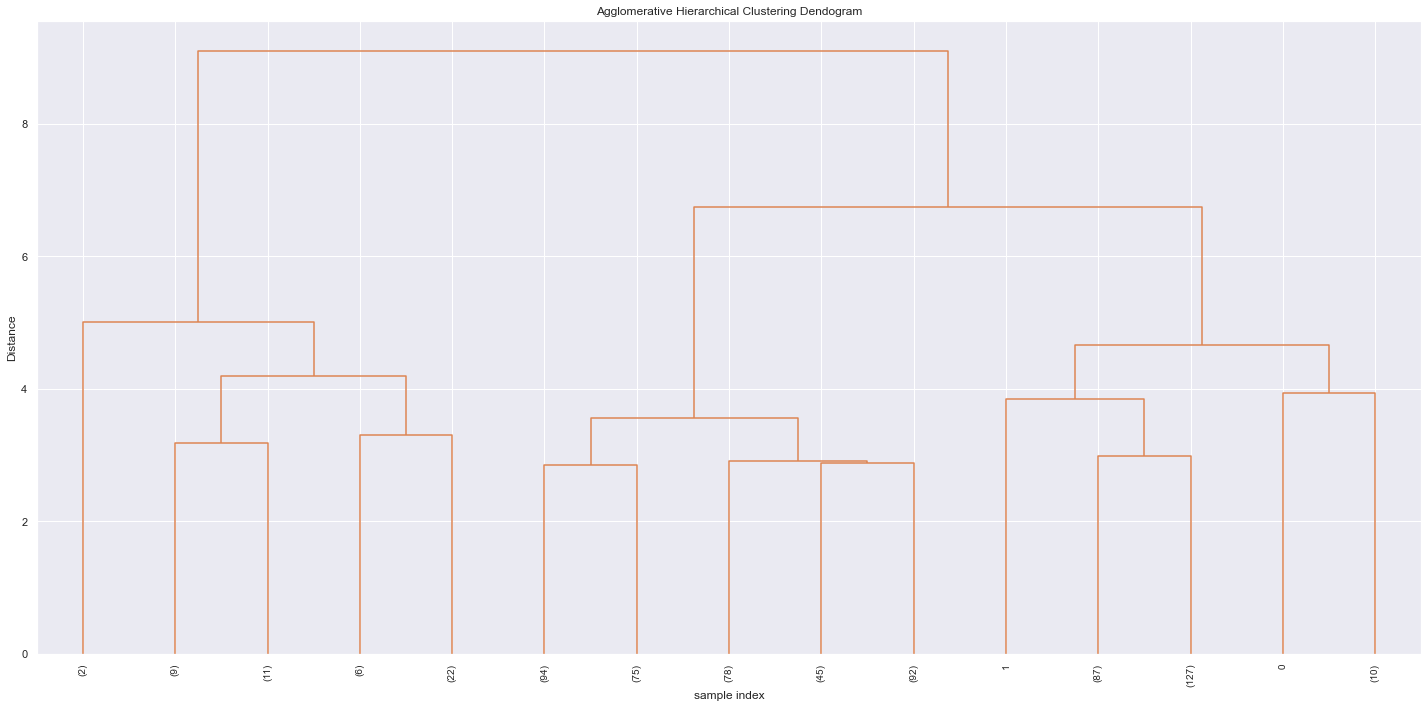

In [32]:
plt.figure(figsize=(20,10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, p=15,truncate_mode='lastp',leaf_rotation=90.,color_threshold=90,  leaf_font_size=10. )
plt.tight_layout()

### Linkage Method : ward

In [33]:
Z = linkage(AllLifeDataScaled, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(AllLifeDataScaled))
c

0.767999831078602

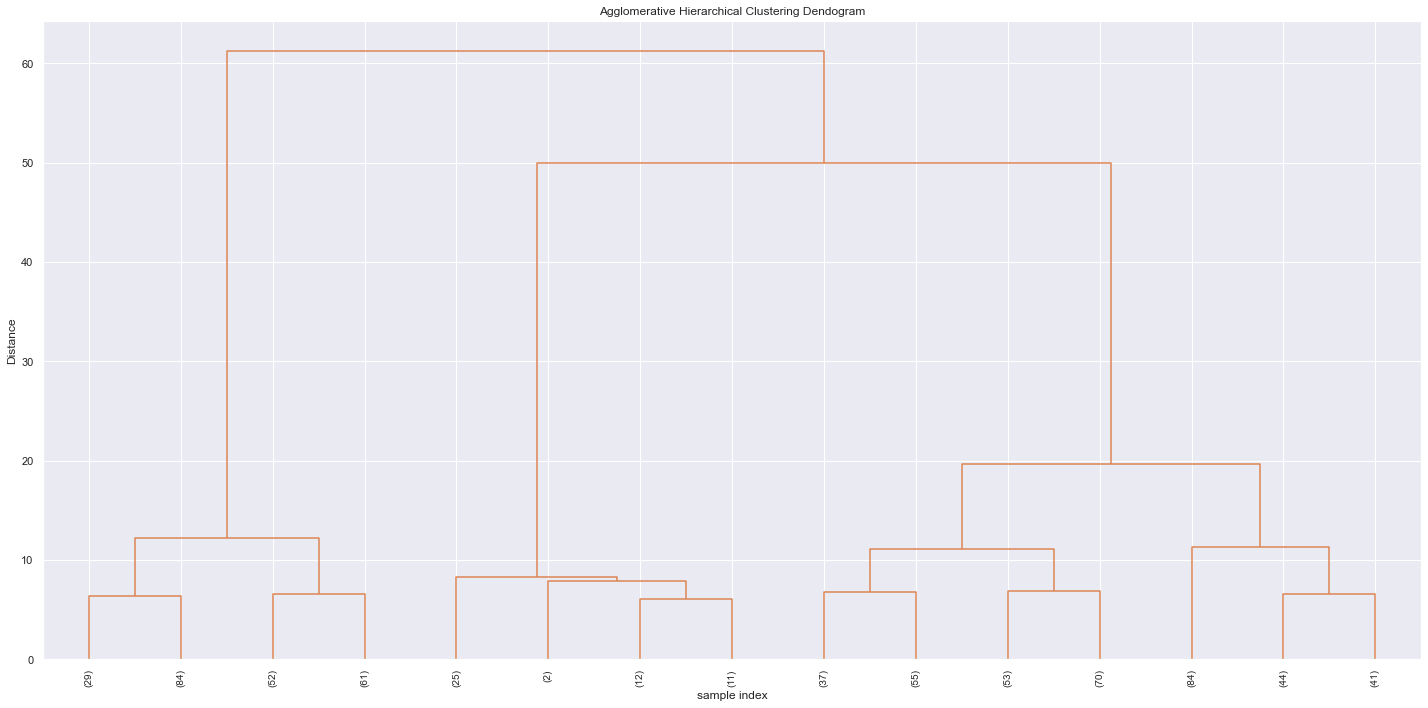

In [34]:
plt.figure(figsize=(20, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, p=15,truncate_mode='lastp',leaf_rotation=90.,color_threshold=600,  leaf_font_size=10. )
plt.tight_layout()

- Plotting Dendogram with various Linkage system shows "Average" has the maximum value for Cophenetic Coefficient 

- Cophenetic Coeefcient with Average Linkage - 0.9276271085759551
- Cophenetic Coeefcient with Average Linkage - 0.920975588820901
- Cophenetic Coeefcient with Average Linkage - 0.8209437128799769

The Cophenetic score and Dendogram method resulted in two clusters, It is also worth noting that the online user segment matches the same online user segment from Kmeans. Once again, online users have more credit cards and a larger credit limit.


In [35]:
model=AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model.fit(AllLifeDataScaled)
preds=model.labels_
AllLifeDataScaled['Hierarchical_GROUP'] = preds

AllLifeDataScaled.groupby('Hierarchical_GROUP').count()

# AllLifeDataScaled.head()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,labels
Hierarchical_GROUP,,,,,,,,
0,50,50,50,50,50,50,50,50
1,610,610,610,610,610,610,610,610


In [36]:
HC=AllLifeDataScaled.groupby('Hierarchical_GROUP').mean().append(pd.DataFrame(AllLifeDataScaled.std()).T)
HC.index=['Offline','Online', 'Mean']
HC


,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,labels,Hierarchical_GROUP
Offline,1.473714,2.831764,1.862226,-1.105763,2.827319,-0.874330,2.000000,1.040000,NaN
Online,-0.120796,-0.232112,-0.152641,0.090636,-0.231747,0.071666,0.629508,0.000000,NaN
Mean,1.000758,1.000758,1.000758,1.000758,1.000758,1.000758,0.589574,0.280643,0.264811


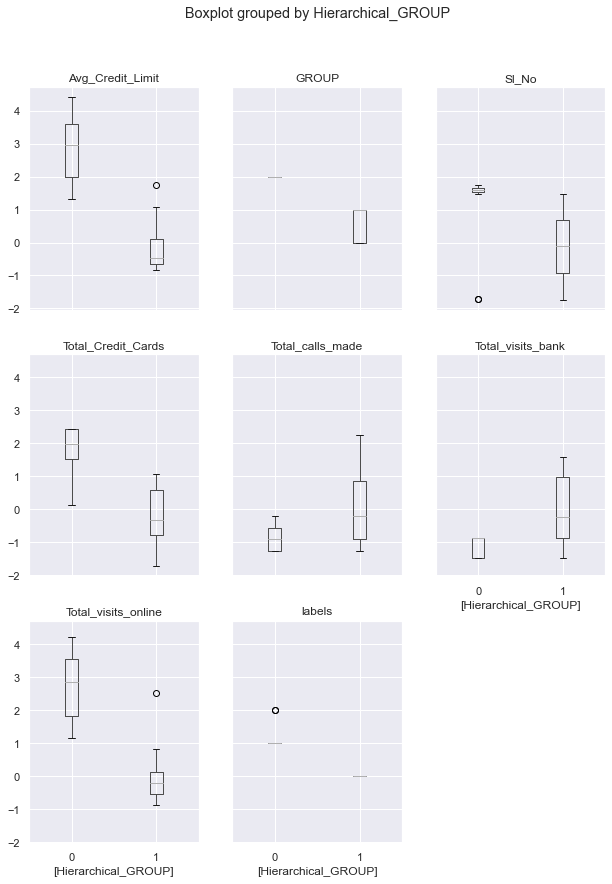

In [39]:

AllLifeDataScaled.boxplot(by='Hierarchical_GROUP',figsize=(10,14));

## Calculating Avg Silhoutte Score 

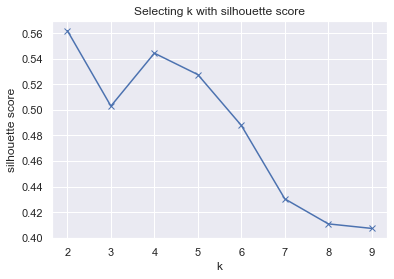

In [44]:
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='average')
    model.fit(AllLifeDataScaled)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(AllLifeDataScaled, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score');

In [41]:
# silhouette score with KMeans Clustering

from sklearn.metrics import silhouette_score
labels = model.labels_
silhouette_score(AllLifeDataScaled, labels, metric='euclidean')



0.4072467112229992

The Comparision of The silhouette_score for KMeans is Lower than Hierarchial Clustering 

## Answer Key Questions

*** How many different segments of customers are there? ***
- there are three distinct categories of customers: Inperson, Phone User & Online User

*** How are these segments different from each other?***
- In-person users: prefer to handle bank transactions in person. They have the fewest credit cards and the lowest available credit. They are also the most active users.
- Phone users: prefer verbally handling transactions remotely.
- Online users: prefer digital transactions. They also have the most credit cards and the highest available credit.

*** What are your recommendations to the bank on how to better market to and service these customers?***

The Bank can tailor contact methods to these customer preferences. 
Online/phone users will probably prefer email/text notifications, 
while in-person users will prefer mail notifications. 

Since online users tend to have the most credit, As a possible example, The Bank may want more customers to switch to digital, as they are more engaged (have more visits) and have more credit cards. 

The Bank should target switching customer for online banking.

